In [1]:
from ridge_extractor import extract_ridge_from_image
from ridge_profile_fit import fit_profile
from skimage.draw import circle_perimeter
from pathlib import Path
import pandas as pd
import pickle

source_dir = Path(r"D:\Messungen\Profilometry\Lasermikroskop\Wetting_Ridge\70vs80")
# R= 0.0002
upsilon = 0.06 # from 10.1002/marc.202000360
gamma = 0.072 # from https://en.wikipedia.org/wiki/Surface_tension

initial_params = {\
    "h" : 0.001,
    "E_lookup" : {"70_S":5000,"70_H":10000,"80_S":15000,"80_H":30000},
    "upsilon" : 0.059, # from 10.1002/marc.202000360
    "gamma" : 0.072, # from https://en.wikipedia.org/wiki/Surface_tension
    "gamma_s": 0.021, # 10.1038/ncomms5369, 10.1103/PhysRevLett.109.038001
    "theta": 100
}

DIPlib -- a quantitative image analysis library
Version 3.4.3 (Mar 21 2024)
For more information see https://diplib.org


In [4]:
# convert numpy arrays from gwyddion to tiffs
import subprocess
from subprocess import run, PIPE, STDOUT
from pathlib import Path
import numpy as np
import json

# preprocess all files
print("-- Preparing data -- ")
#use pathlib to get current working dir
cwd = Path.cwd()
print(cwd)
glb = source_dir.rglob("*f.lext")

for file in glb:
    python2_command = f'C:/Python27/python.exe -W ignore {cwd/"gwypy_lext_processing.py"} -o {Path(file).with_suffix("")} "{Path(file)}"'
    ret = subprocess.check_output(python2_command)
    print(ret.decode())


# import numpy as np
# import tifffile

# glb = source_dir.rglob("*f.npz")
# for file in glb:
#     arr: np.ndarray = np.load(file)["arr_0"]
#     with open(file.with_stem(file.stem +"_img_attr").with_suffix(".txt")) as f:
#         lines = f.readlines()
#         pixelscale =[float(x) for x in lines[2].split(" ")[-2].strip().split(",")]
#     metadata=dict(microscope="LEXT", PhysicalSizeX=pixelscale[0], PhysicalSizeY=pixelscale[1], PhysicalSizeUnit="m")
#     tifffile.imwrite(Path(file).with_suffix(".ome.tif"), arr, 
#                     compression="zlib", compressionargs={'level':9}, tile=(256,256), maxworkers=8,
#                     metadata=metadata, shape=arr.shape, dtype=arr.dtype,
#                     resolution=(1/pixelscale[0], 1/pixelscale[1]), resolutionunit=None)

-- Preparing data -- 
c:\Users\krr38985\Documents\Python\ridge_evaluation
Evaluating Surface Data ...
From files:
['D:\\Messungen\\Profilometry\\Lasermikroskop\\Wetting_Ridge\\70vs80\\70_H_1_f.lext']
Target path: D:\Messungen\Profilometry\Lasermikroskop\Wetting_Ridge\70vs80\70_H_1_f
Loading file D:\Messungen\Profilometry\Lasermikroskop\Wetting_Ridge\70vs80\70_H_1_f.lext
1
Applying transformations
Smoothing
Exporting results ...
(1577229.798311636, 1580060.0422222703)
Done

Evaluating Surface Data ...
From files:
['D:\\Messungen\\Profilometry\\Lasermikroskop\\Wetting_Ridge\\70vs80\\70_H_2_f.lext']
Target path: D:\Messungen\Profilometry\Lasermikroskop\Wetting_Ridge\70vs80\70_H_2_f
Loading file D:\Messungen\Profilometry\Lasermikroskop\Wetting_Ridge\70vs80\70_H_2_f.lext
1
Applying transformations
Smoothing
Exporting results ...
(1577229.798311636, 1580060.0422222703)
Done

Evaluating Surface Data ...
From files:
['D:\\Messungen\\Profilometry\\Lasermikroskop\\Wetting_Ridge\\70vs80\\70_S_1_f

70_H_1_f.ome Center: (1902,2046) Radius: 1152 R2: 0.8806248634129894


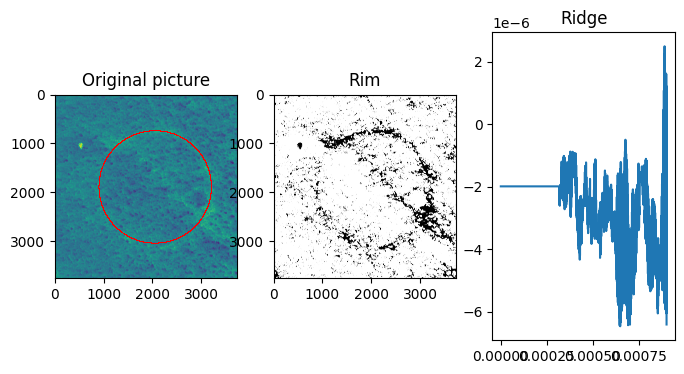

70_H_2_f.ome Center: (2089,1831) Radius: 1432 R2: 0.9048811712051346


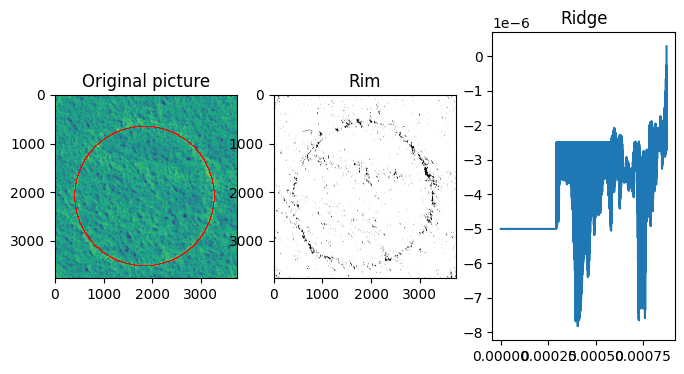

In [2]:
# Extract ridge from images and store as csv
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
glb = source_dir.rglob("*f.ome.tif")
for file in glb:
    try:
        ridge, img, circ_params, rim_binarized = extract_ridge_from_image(file, threshold=0.2, use_kmeans=False)
        cy, cx = circle_perimeter(*circ_params)
        fig2, (ax1, ax2, ax3) = plt.subplots(ncols=3, nrows=1, figsize=(8, 4))

        ax1.set_title('Original picture')
        ax1.imshow(img)
        ax1.plot(cx,cy, "r,")

        ax2.set_title('Rim')
        ax2.imshow(rim_binarized, cmap="Greys")

        ax3.set_title('Ridge')
        ax3.plot(ridge[0], ridge[1])
        plt.tight_layout()
        plt.show()
        df = pd.DataFrame({"x":ridge[0],"y":ridge[1]})
        df.to_csv(file.with_suffix(".rdg"), sep=";")
        
    except Exception as e:
        print(e)
        print(file)
        raise


In [ ]:
# read csvs and fit ridge profile
# files = (source_dir / "70vs80_first").rglob("*2_f.rdg")

# fit_params = dict()
# for f in files:
#     fit_params[str(f)] = fit_profile(f, **initial_params)

# with open(source_dir / "70vs80_first/fit_data.p","wb") as f:
#     pickle.dump(fit_params, f, protocol=pickle.HIGHEST_PROTOCOL)

# files = (source_dir / "70vs80_second").rglob("*2_f.rdg")

# fit_params = dict()
# for f in files:
#     fit_params[str(f)] = fit_profile(f, **initial_params)

# with open(source_dir / "70vs80_second/fit_data.p","wb") as f:
#     pickle.dump(fit_params, f, protocol=pickle.HIGHEST_PROTOCOL)

In [17]:
# read csvs and fit ridge profile
files = (source_dir).rglob("*_1_*.rdg")

fit_params = dict()
for f in files:
    fit_params[str(f)] = fit_profile(f, **initial_params)

with open(source_dir / "fit_data_1.p","wb") as f:
    pickle.dump(fit_params, f, protocol=pickle.HIGHEST_PROTOCOL)

files = (source_dir).rglob("*_2_*.rdg")

fit_params = dict()
for f in files:
    fit_params[str(f)] = fit_profile(f, **initial_params)

with open(source_dir / "fit_data_2.p","wb") as f:
    pickle.dump(fit_params, f, protocol=pickle.HIGHEST_PROTOCOL)

files = (source_dir).rglob("*_4_*.rdg")

fit_params = dict()
for f in files:
    fit_params[str(f)] = fit_profile(f, **initial_params)

with open(source_dir / "fit_data_4.p","wb") as f:
    pickle.dump(fit_params, f, protocol=pickle.HIGHEST_PROTOCOL)

70_H_1 - 0.8
Shanahan:	R2 0.320
Limat:		R2 0.389
Style R>>h:	R2 0.270
Style:		R2 0.055

70_S_1 - 0.6
Shanahan:	R2 0.394
Limat:		R2 0.824
Style R>>h:	R2 -0.243
Style:		R2 0.912

80_H_1 - 0.1
Shanahan:	R2 -20.689
Limat:		R2 -18.016
Style R>>h:	R2 -42.814
Style:		R2 -15.199

80_S_1 - 0.7
Shanahan:	R2 0.849
Limat:		R2 0.273
Style R>>h:	R2 0.830
Style:		R2 0.029

70_H_2 - 0.7
Shanahan:	R2 -3.694
Limat:		R2 -5.180
Style R>>h:	R2 -6.195
Style:		R2 -1.798

70_S_2 - 0.6
Shanahan:	R2 0.612
Limat:		R2 0.773
Style R>>h:	R2 0.099
Style:		R2 0.709

80_H_2 - 0.8
Shanahan:	R2 -13.127
Limat:		R2 -8.417
Style R>>h:	R2 -12.234
Style:		R2 -10.895

80_S_2 - 0.9
Shanahan:	R2 0.524
Limat:		R2 0.051
Style R>>h:	R2 0.656
Style:		R2 0.086

80_S_4 - 1.0
Shanahan:	R2 0.371
Limat:		R2 -0.428
Style R>>h:	R2 0.453
Style:		R2 -0.279



In [ ]:
import pickle
from IPython.display import display, Markdown

with open(r"D:\Messungen\Profilometry\Lasermikroskop\Wetting_Ridge\70vs80_first\fit_data.p","rb") as f:
    fit_params: dict[str, dict[str,RidgeFit]] = pickle.load(f)

sha_md = ["| Sample | d | 𝜃 | E | R2 |","| --- | --- | --- | --- | --- |"]
lim_md = ["| Sample | 𝛾ₛ | 𝜃 | E |R2 |","| --- | --- | --- | --- | --- |"]
st_ld_md = ["| Sample | 𝛶ₛ | h | E |R2 |","| --- | --- | --- | --- | --- |"]
st_ex_md = ["| Sample | 𝛶ₛ | h | E | R2 |","| --- | --- | --- | --- | --- |"]

for fit_name, ridgefit in fit_params.items():
    fit = ridgefit["shanahan"]
    popt, perr = fit.popt, fit.perr
    sha_md.append(f"|{fit.iron_content}_{fit.shear_mod}_{fit.volume}|{popt[1]:1.4e}±{perr[1]:1.2e}|{popt[0]:.1f}±{perr[0]:.1f}°|{popt[2]:.1f}±{perr[2]:.1f} Pa|{fit.r2}")
    fit = ridgefit["limat"]
    popt, perr = fit.popt, fit.perr
    lim_md.append(f"|{fit.iron_content}_{fit.shear_mod}_{fit.volume}|{popt[0]:.4f}±{perr[0]:.4f} N/m|{popt[1]:.1f}±{perr[1]:.1f}°|{popt[2]:.1f}±{perr[2]:.1f} Pa|{fit.r2}")
    fit = ridgefit["style_ld"]
    popt, perr = fit.popt, fit.perr
    st_ld_md.append(f"|{fit.iron_content}_{fit.shear_mod}_{fit.volume}|{popt[0]:.4f}±{perr[0]:.4f} N/m|{popt[2]*1000:.3f}±{perr[2]*1000:.3f} mm|{popt[1]:.1f}±{perr[1]:.1f} Pa|{fit.r2}")
    fit = ridgefit["style"]
    popt, perr = fit.popt, fit.perr
    st_ex_md.append(f"|{fit.iron_content}_{fit.shear_mod}_{fit.volume}|{popt[0]:.4f}±{perr[0]:.4f} N/m|{popt[2]*1000:.3f}±{perr[2]*1000:.3f} mm|{popt[1]:.1f}±{perr[1]:.1f} Pa|{fit.r2}")

sha_md = "\n".join(sha_md)
lim_md = "\n".join(lim_md)
st_ld_md = "\n".join(st_ld_md)
st_ex_md = "\n".join(st_ex_md)

display(Markdown("## Shanahan\n\n" + sha_md + "\n## Limat\n\n" + lim_md + "\n## Style\n### R>>h\n" + st_ld_md + "\n### exact\n" + st_ex_md))

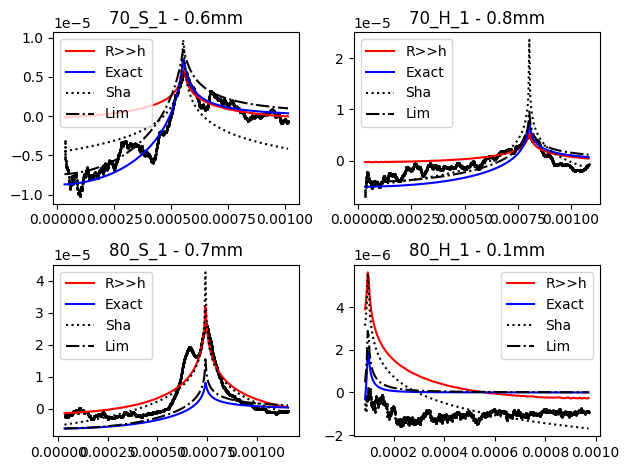

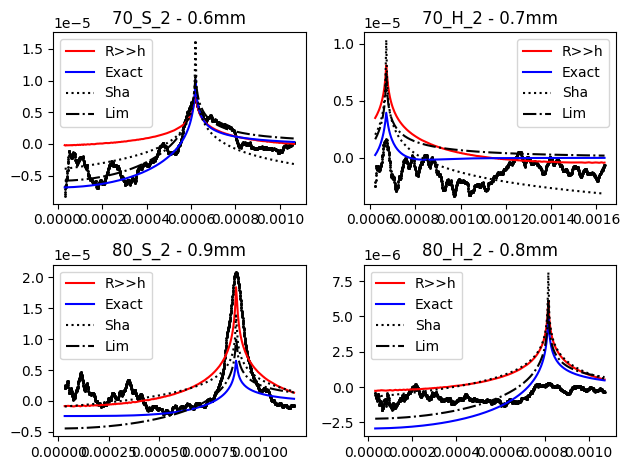

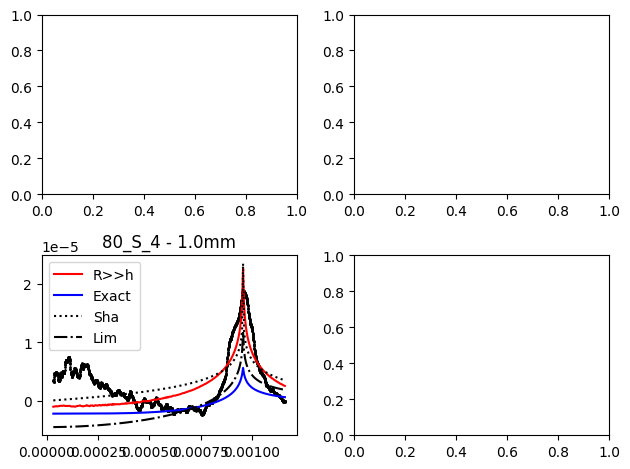

In [18]:
import pickle
import numpy as np
from data_types import RidgeFit
from ridge_models import style_exact, style_ld_ts, shanahan, limat_symmetric

def plot_fits(fit_pickle: Path):

    with open(fit_pickle, "rb") as f:
        fit_params: dict[str, dict[str, RidgeFit]] = pickle.load(f)

    from matplotlib import pyplot as plt
    fig, ax = plt.subplots(2,2)
    i=0
    for fit_name, fit in fit_params.items():
        
        # drop, popt_ld_ts, popt_hemi, pcov_ld_ts, pcov_hemi, x_ax, defl = fit
        # vol, R, G, Fe = drop
        i = 0 if fit["style"].shear_mod == "S" else 1
        j = 0 if fit["style"].iron_content == "70" else 1
        plt.sca(ax[j,i])
        fit_x = np.linspace(fit["style"].x_values.min(), fit["style"].x_values.max(), 250)

        plt.plot(fit["style"].x_values, fit["style"].y_values,"k.", markersize=2)
        rf = fit["style_ld"]
        plt.plot(fit_x, style_ld_ts(fit_x, rf.gamma, rf.radius, *rf.popt), "r-", label='R>>h')
        rf = fit["style"]
        plt.plot(fit_x, style_exact(fit_x, rf.gamma, rf.radius, *rf.popt), "b-", label="Exact")
        rf = fit["shanahan"]
        plt.plot(fit_x, shanahan(fit_x, rf.gamma, rf.radius, *rf.popt), "k:", label="Sha")
        rf = fit["limat"]
        plt.plot(fit_x, limat_symmetric(fit_x, rf.gamma, rf.radius, *rf.popt), "k-.", label="Lim")
        r = fit["style"].radius*1000
        plt.title(f"{fit["style"].iron_content}_{fit["style"].shear_mod}_{fit["style"].volume} - {r:.1f}mm")
        plt.legend()
        i+=1
    plt.tight_layout()
    plt.show()

# plot_fits(source_dir / "70vs80_first/fit_data.p")
# plot_fits(source_dir / "70vs80_second/fit_data.p")
plot_fits(source_dir / "fit_data_1.p")
plot_fits(source_dir / "fit_data_2.p")
plot_fits(source_dir / "fit_data_4.p")